# Head Pose Estimation

The project head pose estimation aims to estimate the angles of head rotation in three direction, namely pitch, yaw and roll. The project uses mediapipe library to obtain 2D landmarks of 468 points on the face. The points are then used to train a machine learning model able to estimate the rotation in 3D space so the problem is not considered deterministic and cannot be solved mathematically and this calls for the use of machine learning.

<img src="pitch_yaw_roll.png" width="500">

### Installation and Setup

In [ ]:
!pip install mediapipe

In [2]:
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import os
import glob
import csv
import scipy.io as sio
from math import sin, cos
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Image Names Extraction and Visualization

In [4]:
#gather names of images
directory = '/content/drive/MyDrive/AFLW2000'
imgs_names = [file_name for file_name in os.listdir(directory) if file_name.endswith('.jpg')]
mat_files = [file_name for file_name in os.listdir(directory) if file_name.endswith('.mat')]

In [5]:
print(imgs_names[:5])

['image03209.jpg', 'image03252.jpg', 'image03345.jpg', 'image03356.jpg', 'image03349.jpg']


In [6]:
focus_pts = [151, 168, 4, 294, 64, 362, 263, 133, 33, 0, 17, 175, 223, 443, 144, 373, 162, 389] 

In [7]:
mp_face_mesh = mp.solutions.face_mesh

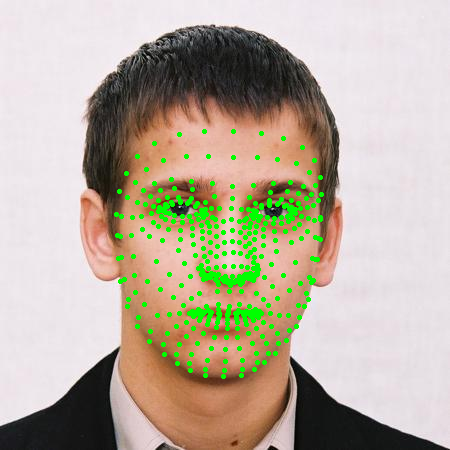

In [8]:
with mp_face_mesh.FaceMesh(static_image_mode=True) as face_mesh:
  #read image
  image = cv2.imread(directory+'/image00053.jpg')
  #convert image from BGR to RGB and process
  results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  #get the image shape
  shape = image.shape

  if results.multi_face_landmarks != None:
    #loop over the faces
    for face in results.multi_face_landmarks:
      #for each point
      for landmark in face.landmark:
        x = landmark.x
        y = landmark.y

        #in order to draw, mutliply by size
        relative_x = int(x*shape[1]) #multiply by height
        relative_y = int(y*shape[0]) #mutliply by width

        cv2.circle(image, (relative_x, relative_y), radius=1, color=(0,255,0), thickness=2)
    cv2_imshow(image)

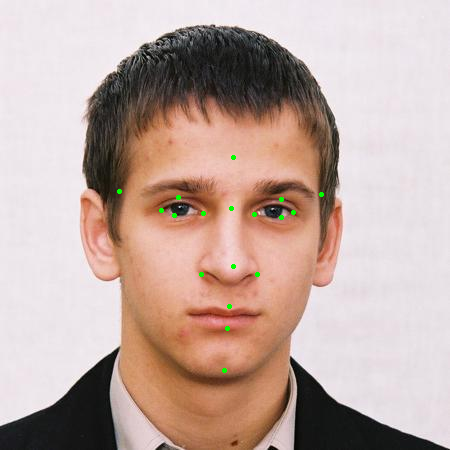

In [9]:
#choosing specific points
with mp_face_mesh.FaceMesh(static_image_mode=True) as face_mesh:
  #read image
  image = cv2.imread(directory+'/image00053.jpg')
  #convert image from BGR to RGB and process
  results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  #get the image shape
  shape = image.shape

  if results.multi_face_landmarks != None:
    #loop over the faces
    for face in results.multi_face_landmarks:
      #for each point
      for point in focus_pts:
        x = face.landmark[point].x
        y = face.landmark[point].y

        #in order to draw, mutliply by size
        relative_x = int(x*shape[1]) #multiply by width
        relative_y = int(y*shape[0]) #mutliply by length

        cv2.circle(image, (relative_x, relative_y), radius=1, color=(0,255,0), thickness=2)
    cv2_imshow(image)

### Data Extraction / Dataset Creation

In [10]:
#get pitch, yaw, roll
def get_pyr(mat_path):
  mat_file = sio.loadmat(mat_path)
  return list(mat_file['Pose_Para'][0][:3])

In [11]:
landmarks = []
for col in range(0,468):
  landmarks += ['x{}'.format(col+1), 'y{}'.format(col+1)]

In [12]:
print(landmarks[:6])

['x1', 'y1', 'x2', 'y2', 'x3', 'y3']


In [13]:
with open('head_pose_dataset.csv', mode='w') as f:
  csv_writer = csv.writer(f, delimiter=',')
  csv_writer.writerow(landmarks)

In [14]:
#define list for row/features and 3 lists for the target labels
rows = []
pitch_list = []
yaw_list = []
roll_list = []

with mp_face_mesh.FaceMesh(static_image_mode=True) as face_mesh:

  for img in imgs_names:
    #read image
    image = cv2.imread(directory+'/'+img)
    #convert image from BGR to RGB and process
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #get the image shape
    shape = image.shape

    if results.multi_face_landmarks != None:
      #loop over the faces
      for face in results.multi_face_landmarks:
        
        #obtain the ground truth from .mat file
        #[pitch yaw roll]
        all_pose_para = get_pyr(directory+'/'+img[:-3]+'mat')
        pitch = all_pose_para[0]
        yaw = all_pose_para[1]
        roll = all_pose_para[2]

        #append to list the target labels
        pitch_list.append(pitch)
        yaw_list.append(yaw)
        roll_list.append(roll)
        
        #choose the chosen points to normalize
        #nose point 4
        nose_pt_x, nose_pt_y = face.landmark[4].x, face.landmark[4].y
        #forehead point 10
        forehead_pt_x, forehead_pt_y = face.landmark[10].x, face.landmark[10].y

        #un-normalize points to get their location
        nose_pt_x, nose_pt_y = int(nose_pt_x * shape[1]), int(nose_pt_y * shape[0])
        forehead_pt_x, forehead_pt_y = int(forehead_pt_x * shape[1]), int(forehead_pt_y * shape[0])

        #calculate the distance
        nose_pt = np.array([nose_pt_x, nose_pt_y])
        forehead_pt = np.array([forehead_pt_x, forehead_pt_y])
        distance = np.linalg.norm(nose_pt - forehead_pt)

        face_row = list(np.array([[((lm.x * shape[1]) - nose_pt_x)/distance, ((lm.y * shape[0]) - nose_pt_y)/distance] for lm in face.landmark]).flatten())
        #if you want to know which image
        #face_row += [img] 
        rows.append(face_row)

        with open('/content/head_pose_dataset.csv', mode='a') as f:
            csv_writer = csv.writer(f, delimiter=',')
            csv_writer.writerow(face_row)

In [15]:
print(len(pitch_list))
print(len(yaw_list))
print(len(roll_list))

1853
1853
1853


In [16]:
pose_data = pd.read_csv('/content/head_pose_dataset.csv')
pose_data.head()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,x464,y464,x465,y465,x466,y466,x467,y467,x468,y468
0,0.067030,0.328205,0.000895,0.084330,0.109037,0.177909,0.093921,-0.149767,0.005139,0.008122,...,0.518581,-0.272850,0.462333,-0.260575,0.411546,-0.252619,0.844953,-0.231329,0.897006,-0.255406
1,0.009322,0.595813,0.015251,0.118809,-0.005072,0.359897,-0.124509,-0.136488,0.012932,0.002051,...,0.215131,-0.175605,0.156900,-0.169538,0.129904,-0.184685,0.684021,-0.134949,0.750501,-0.193360
2,0.123301,0.333559,0.013915,0.078694,0.166921,0.180381,0.103639,-0.144438,0.007269,0.003677,...,0.522467,-0.303719,0.470179,-0.286893,0.417817,-0.275312,0.820107,-0.311576,0.875300,-0.340237
3,-0.076576,0.345102,0.002309,0.086475,-0.073506,0.175926,-0.114812,-0.158177,0.008806,0.005363,...,-0.007835,-0.306598,-0.031811,-0.293584,-0.033024,-0.286440,0.294092,-0.308274,0.332659,-0.342919
4,0.123781,0.232474,0.021969,0.060497,0.104812,0.085345,-0.013593,-0.167524,0.004959,0.003812,...,0.291112,-0.442346,0.248447,-0.411016,0.214658,-0.382450,0.632065,-0.504500,0.670066,-0.553568


In [17]:
pose_data['pitch'] = pitch_list
pose_data['yaw'] = yaw_list
pose_data['roll'] = roll_list

In [18]:
pose_data.head()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,y465,x466,y466,x467,y467,x468,y468,pitch,yaw,roll
0,0.067030,0.328205,0.000895,0.084330,0.109037,0.177909,0.093921,-0.149767,0.005139,0.008122,...,-0.260575,0.411546,-0.252619,0.844953,-0.231329,0.897006,-0.255406,0.107997,0.837121,0.249012
1,0.009322,0.595813,0.015251,0.118809,-0.005072,0.359897,-0.124509,-0.136488,0.012932,0.002051,...,-0.169538,0.129904,-0.184685,0.684021,-0.134949,0.750501,-0.193360,0.404001,-0.131908,-0.084306
2,0.123301,0.333559,0.013915,0.078694,0.166921,0.180381,0.103639,-0.144438,0.007269,0.003677,...,-0.286893,0.417817,-0.275312,0.820107,-0.311576,0.875300,-0.340237,0.106887,0.921113,0.128691
3,-0.076576,0.345102,0.002309,0.086475,-0.073506,0.175926,-0.114812,-0.158177,0.008806,0.005363,...,-0.293584,-0.033024,-0.286440,0.294092,-0.308274,0.332659,-0.342919,-0.067951,-0.425775,0.023097
4,0.123781,0.232474,0.021969,0.060497,0.104812,0.085345,-0.013593,-0.167524,0.004959,0.003812,...,-0.411016,0.214658,-0.382450,0.632065,-0.504500,0.670066,-0.553568,-0.373085,0.293578,-0.125011


In [19]:
pose_data.to_csv('head_pose_dataset.csv', index=False)